In [1]:
# Import required libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import seaborn as sns

In [2]:
# Install kaggle
!pip install kaggle

In [3]:
# Upload json file to integrate with kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shakeelahmedshaik","key":"7ee0f9a75504fe8b80a31696738bf91c"}'}

In [4]:
# Make a new directory named kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download the dataset
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 92% 200M/218M [00:00<00:00, 207MB/s]
100% 218M/218M [00:01<00:00, 221MB/s]


In [6]:
# Unzip the dataset
import zipfile
with zipfile.ZipFile('cat-and-dog.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [7]:
# Example: Load and prepare data (adjust as per your actual data loading mechanism)
train_dir = './training_set/training_set'
test_dir = './test_set/test_set'


In [8]:

# Load data using torchvision or custom loader (assuming already transformed to tensors)
# Example using torchvision.transforms and datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [9]:
# Import required libraries
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader




In [10]:
# Define constants
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 64

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}



In [11]:
# Paths to the dataset
train_dir = './training_set/training_set'
validation_dir = './test_set/test_set'



In [12]:
# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(validation_dir, transform=data_transforms['val'])



In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [14]:
# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train dataset size: 8005
Validation dataset size: 2023
Classes: ['cats', 'dogs']


In [15]:
import torch
import torchvision.models as models

# Use a pre-trained ResNet model for feature extraction
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))  # Remove the final classification layer

# Set the model to evaluation mode
resnet.eval()

def extract_features(loader):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, label in loader:
            output = resnet(inputs)
            output = output.view(output.size(0), -1)
            features.extend(output.numpy())
            labels.extend(label.numpy())
    return features, labels

# Extract features from the train and validation sets
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.4MB/s]


In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Train an SVM model with RBF kernel
svm_model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model_rbf.fit(train_features, train_labels)


SVC()

In [17]:
import joblib
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(svm_model_rbf, 'svm_model_rbf.pkl')

['svm_model_rbf.pkl']

In [18]:
from sklearn.metrics import accuracy_score

# Predict on the validation set
predictions_rbf = svm_model_rbf.predict(val_features)
accuracy_rbf = accuracy_score(val_labels, predictions_rbf)
print(f"Accuracy of SVM model with RBF kernel: {accuracy_rbf * 100:.2f}%")


Accuracy of SVM model with RBF kernel: 97.78%


In [19]:
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix # Import confusion_matrix
conf_matrix = confusion_matrix(val_labels, predictions_rbf)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[991  20]
 [ 25 987]]


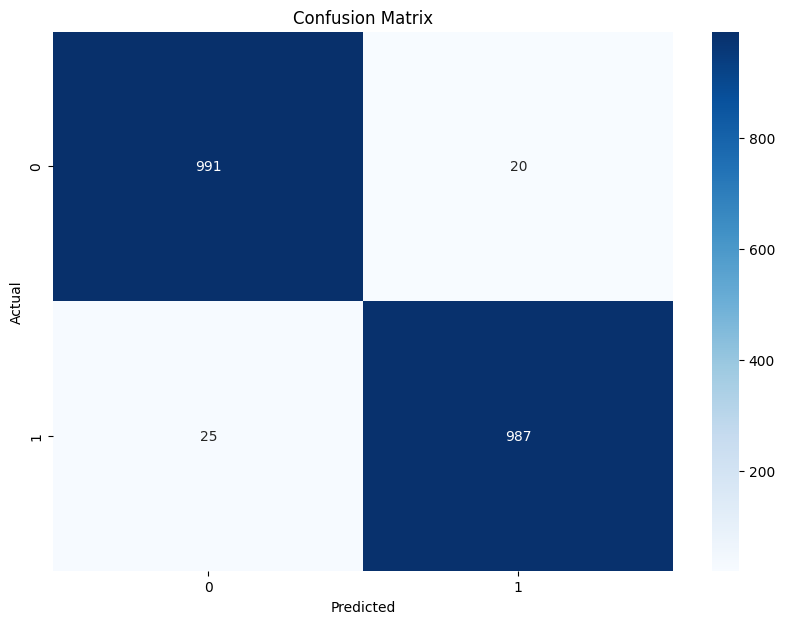

In [20]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(val_labels), yticklabels=set(val_labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
class_report = classification_report(val_labels, predictions_rbf)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1011
           1       0.98      0.98      0.98      1012

    accuracy                           0.98      2023
   macro avg       0.98      0.98      0.98      2023
weighted avg       0.98      0.98      0.98      2023



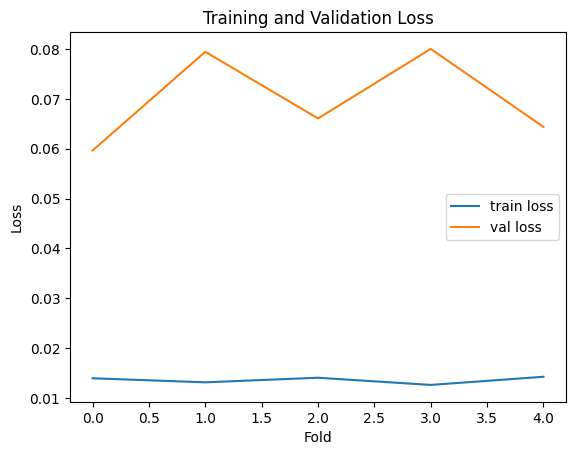

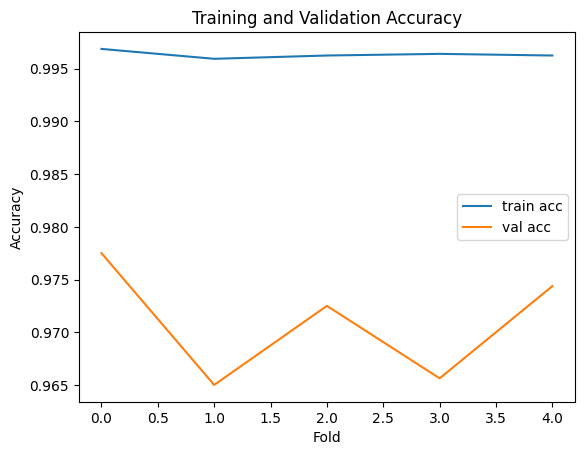

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

# Assuming train_features and train_labels are already defined
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
train_labels = np.array(train_labels)  # Ensure labels are a NumPy array

# Initialize KFold cross-validator
kf = KFold(n_splits=5)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Perform cross-validation
for train_index, val_index in kf.split(train_features):
    X_train, X_val = train_features[train_index], train_features[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Train SVM model with RBF kernel
    svm_model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    svm_model_rbf.fit(X_train, y_train)

    # Predict probabilities
    train_probs = svm_model_rbf.predict_proba(X_train)
    val_probs = svm_model_rbf.predict_proba(X_val)

    # Calculate log loss
    train_loss = log_loss(y_train, train_probs)
    val_loss = log_loss(y_val, val_probs)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate accuracy
    train_accuracy = accuracy_score(y_train, svm_model_rbf.predict(X_train))
    val_accuracy = accuracy_score(y_val, svm_model_rbf.predict(X_val))

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Plot the loss
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# Plot the accuracy
plt.plot(train_accuracies, label='train acc')
plt.plot(val_accuracies, label='val acc')
plt.legend()
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()


In [23]:
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Assuming train_features and train_labels are already defined
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

# Train the SVM model with RBF kernel
svm_model_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
svm_model_rbf.fit(train_features, train_labels)

# Save the scaler and model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(svm_model_rbf, 'svm_model_rbf.pkl')


['svm_model_rbf.pkl']

In [24]:
import numpy as np
import os
from PIL import Image
from sklearn.decomposition import PCA
import joblib

# Define the paths to your image directories
train_dir = './training_set/training_set'

# Preprocess the image for the model (e.g., resizing, scaling)
def preprocess_image(image):
    image = image.resize((32, 32))  # Example resizing
    image_array = np.array(image).flatten() / 255.0  # Normalize to [0, 1]
    return image_array

# Load all training images and preprocess them
def load_and_preprocess_images(directory):
    all_images = []
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            try:
                image = Image.open(image_path).convert('RGB')
                processed_image = preprocess_image(image)
                all_images.append(processed_image)
            except (IOError, OSError):
                print(f"Skipping non-image file: {image_path}")
    return np.array(all_images)

# Load and preprocess all training images
training_images = load_and_preprocess_images(train_dir)

# Fit PCA to reduce dimensionality to 512 features
pca = PCA(n_components=512)
training_images_pca = pca.fit_transform(training_images)

# Save the PCA model
joblib.dump(pca, 'pca_model.pkl')


Skipping non-image file: ./training_set/training_set/dogs/_DS_Store
Skipping non-image file: ./training_set/training_set/cats/_DS_Store


['pca_model.pkl']

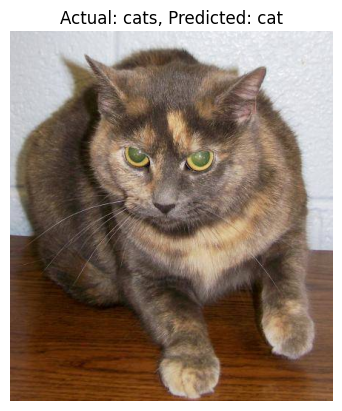

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import joblib

# Define the paths to your image directories
train_dir = './training_set/training_set'
val_dir = './test_set/test_set'

# Load a random image from the specified directory
def load_random_image(directory):
    categories = os.listdir(directory)
    category = random.choice(categories)
    category_path = os.path.join(directory, category)
    image_name = random.choice(os.listdir(category_path))
    image_path = os.path.join(category_path, image_name)
    image = Image.open(image_path).convert('RGB')
    return image, category

# Preprocess the image for the model (e.g., resizing, scaling)
def preprocess_image(image):
    image = image.resize((32, 32))  # Resize to match PCA training
    image_array = np.array(image).flatten() / 255.0  # Normalize to [0, 1]
    return image_array

# Load the scaler, PCA, and trained model
scaler = joblib.load('scaler.pkl')
pca = joblib.load('pca_model.pkl')
svm_model_rbf = joblib.load('svm_model_rbf.pkl')

# Function to predict and display an image
def predict_and_display_random_image(directory):
    random_image, actual_category = load_random_image(directory)
    processed_image = preprocess_image(random_image)
    processed_image_pca = pca.transform([processed_image])  # Apply PCA transformation
    processed_image_scaled = scaler.transform(processed_image_pca)  # Scale the PCA-transformed features
    prediction = svm_model_rbf.predict(processed_image_scaled)
    predicted_category = 'cat' if prediction[0] == 0 else 'dog'
    plt.imshow(random_image)
    plt.title(f'Actual: {actual_category}, Predicted: {predicted_category}')
    plt.axis('off')
    plt.show()

# Predict and display a random image from the training set
predict_and_display_random_image(train_dir)


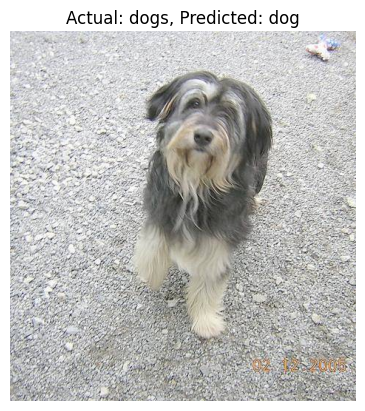

In [72]:
# Predict and display a random image from the training set
predict_and_display_random_image(train_dir)